<a href="https://colab.research.google.com/github/JoseManuel1007/Precio-spot-energia-Jap-n/blob/main/Precio_spot_energ%C3%ADa_Japon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Colab cache for faster access to the 'jepx-dayaheadmarket' dataset.


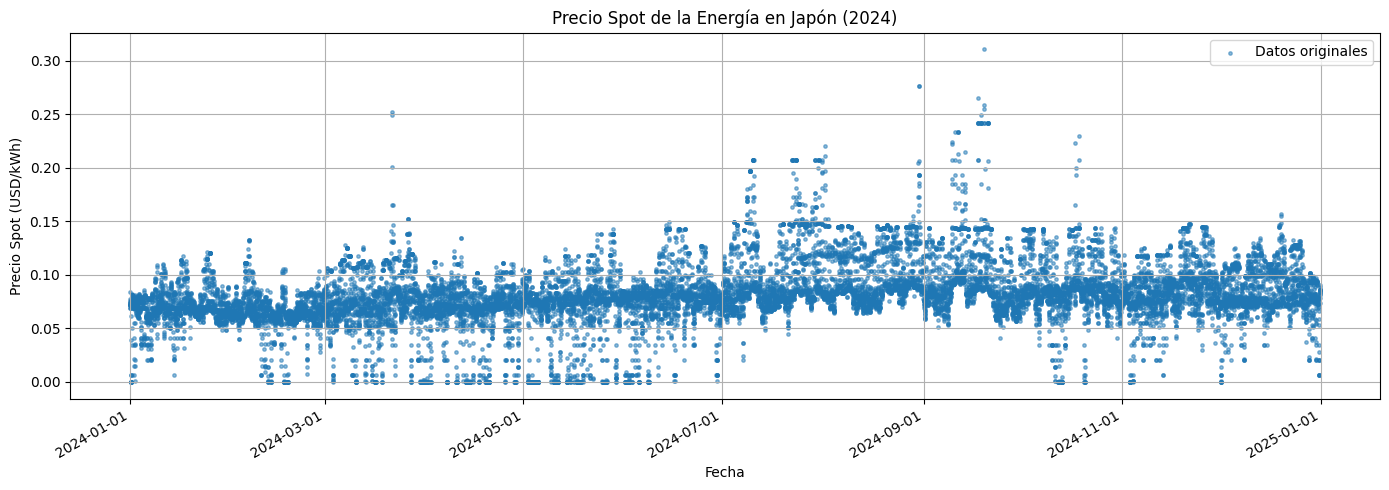

/tmp/ipython-input-4269529708.py:55: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_interpolated = df_interpolated.set_index("date_time").resample("30T").interpolate("time")


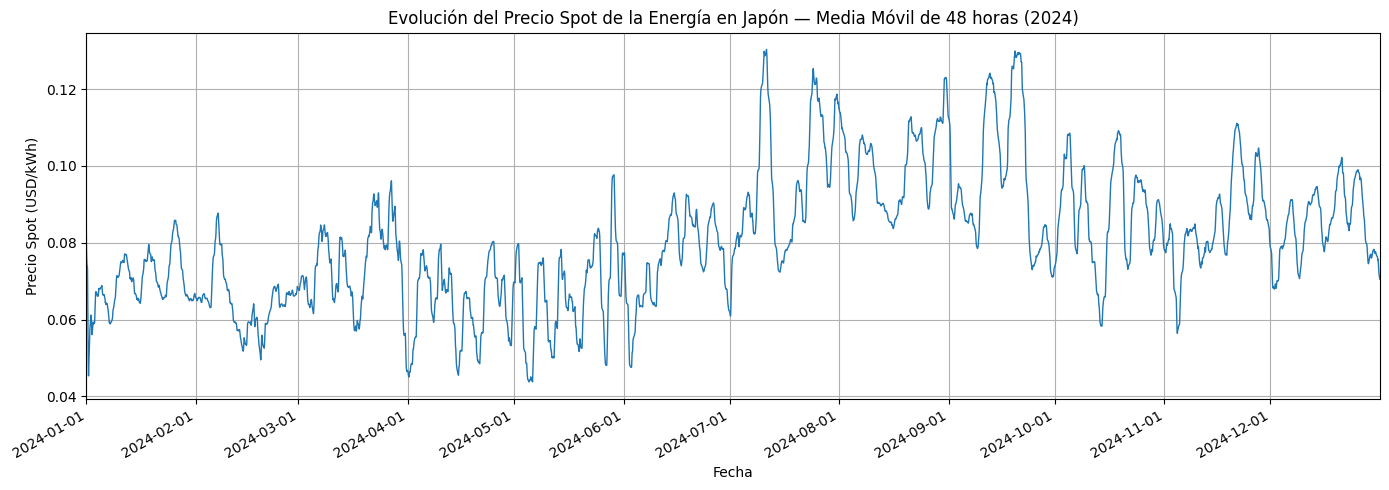

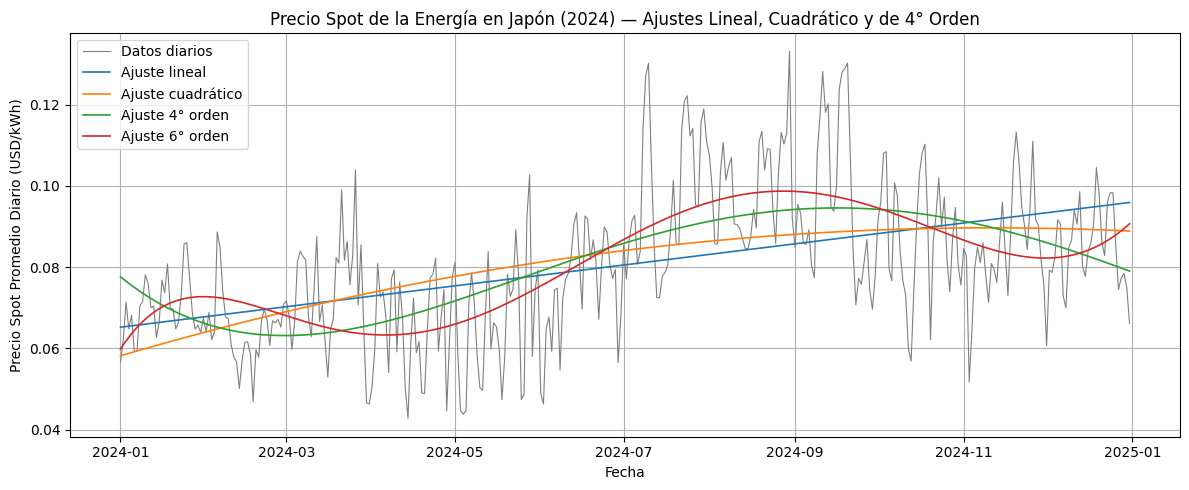

In [13]:
import os
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import AutoDateLocator, DateFormatter
import numpy as np
from numpy.polynomial import Polynomial

# Configuración
YEAR = 2024
DATASET = "mitsuyasuhoshino/jepx-dayaheadmarket"
USD_PER_YEN = 1 / 145
ROLLING_HOURS = 48
FREQ_MIN = "30T"
IQR_MULTIPLIER = 1.5

# Descargar dataset
path = kagglehub.dataset_download(DATASET)
files = os.listdir(path)
csv_files = [f for f in files if f.lower().endswith(".csv")]
if not csv_files:
    raise FileNotFoundError(f"No se encontró ningún CSV en {path}. Archivos: {files}")
csv_path = os.path.join(path, csv_files[0])

# Cargar datos
df = pd.read_csv(csv_path)
df["date_time"] = pd.to_datetime(df["date_time"], errors="coerce")
df = df.dropna(subset=["date_time"]).sort_values("date_time").reset_index(drop=True)

# Filtrar año
df_year = df[df["date_time"].dt.year == YEAR].copy()
df_year["System price USD"] = df_year["System price"] * USD_PER_YEN

# Gráfico del precio spot original
fig, ax = plt.subplots(figsize=(14,5))
ax.scatter(df_year["date_time"], df_year["System price USD"], s=6, alpha=0.5, label="Datos originales")
ax.set_title(f"Precio Spot de la Energía en Japón ({YEAR})")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio Spot (USD/kWh)")
ax.legend()
ax.grid(True)
locator = AutoDateLocator()
formatter = DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig(f"jepx_spot_price_original_{YEAR}.png", dpi=200)
plt.show()

# Promedio móvil 48h
df_interpolated = df_year.copy()
df_interpolated["date_time"] = pd.to_datetime(df_interpolated["date_time"])
df_interpolated = df_interpolated.set_index("date_time").resample("30T").interpolate("time")

window_periods = int(ROLLING_HOURS * 60 / 30)
fig2, ax2 = plt.subplots(figsize=(14,5))
rolling_series = df_interpolated["System price USD"].rolling(window=window_periods, min_periods=1).mean()
ax2.plot(df_interpolated.index, rolling_series, linewidth=1.0)
ax2.set_xlim(df_interpolated.index.min(), df_interpolated.index.max())
ax2.set_title(f"Evolución del Precio Spot de la Energía en Japón — Media Móvil de {ROLLING_HOURS} horas ({YEAR})")
ax2.set_xlabel("Fecha")
ax2.set_ylabel("Precio Spot (USD/kWh)")
ax2.grid(True)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig(f"jepx_system_price_usd_rolling_mean_{ROLLING_HOURS}h_{YEAR}.png", dpi=200)
plt.show()

# Ajuste de modelos lineal, cuadrático y de 4º orden
df_daily = df_interpolated["System price USD"].resample("D").mean().dropna()
t = np.arange(len(df_daily))
y = df_daily.values

poly1 = Polynomial.fit(t, y, 1)
poly2 = Polynomial.fit(t, y, 2)
poly4 = Polynomial.fit(t, y, 4)
poly6 = Polynomial.fit(t, y, 6)

y1 = poly1(t)
y2 = poly2(t)
y4 = poly4(t)
y6= poly6(t)

plt.figure(figsize=(12,5))
plt.plot(df_daily.index, y, label="Datos diarios", color="gray", linewidth=0.8)
plt.plot(df_daily.index, y1, label="Ajuste lineal", linewidth=1.2)
plt.plot(df_daily.index, y2, label="Ajuste cuadrático", linewidth=1.2)
plt.plot(df_daily.index, y4, label="Ajuste 4° orden", linewidth=1.2)
plt.plot(df_daily.index, y6, label="Ajuste 6° orden", linewidth=1.2)
plt.title(f"Precio Spot de la Energía en Japón ({YEAR}) — Ajustes Lineal, Cuadrático y de 4° Orden")
plt.xlabel("Fecha")
plt.ylabel("Precio Spot Promedio Diario (USD/kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"jepx_spot_price_trend_models_{YEAR}.png", dpi=200)
plt.show()


# Informe de Análisis — Precio Spot de la Energía en Japón (2024)

## 1. Mejor método de interpolación
La interpolación con promedio móvil de 48 horas fue la que mejor representó el comportamiento del precio spot de la energía.  
Los intervalos más cortos mostraron mucha variabilidad y ruido, mientras que los más largos suavizaron en exceso las fluctuaciones relevantes.  
Con esta ventana de tiempo se logró un equilibrio adecuado entre la estabilidad de la serie y la conservación de los cambios reales del mercado.

## 2. Modelo de ajuste y sobreajuste
El modelo cuadrático fue el que mejor capturó la tendencia general sin caer en sobreajuste.  
El modelo lineal no reflejó adecuadamente las variaciones estacionales, y los modelos de orden superior tendieron a ajustarse al ruido de los datos.  
El ajuste cuadrático permitió representar la evolución del precio de manera sencilla y coherente con la dinámica observada.

## 3. Interpretación física de las tendencias
La forma cuadrática del modelo refleja los periodos de aumento y disminución en los precios a lo largo del año, asociados a la variación en la demanda y a los cambios en la oferta energética.  
El incremento en determinados meses puede relacionarse con picos de consumo o con condiciones climáticas, mientras que las caídas reflejan momentos de menor demanda o mayor disponibilidad de generación.
